In [5]:
from google.colab import files
files.upload()  # Sube kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


# Instalación de dependencias
Esta celda instala las bibliotecas necesarias como `torch`, `transformers`, `pandas`, `scikit-learn`, y otras para manejar el dataset, el modelo y las métricas.

In [6]:
!pip install datasets torch transformers kaggle pandas scikit-learn matplotlib seaborn -q

# Configuración inicial
Aquí importamos las librerías necesarias y configuramos el dispositivo (CPU o GPU) para el entrenamiento del modelo Transformer.

In [7]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from google.colab import files
import kagglehub
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Configurando entorno ===")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

=== Configurando entorno ===
Dispositivo: cuda


# Descarga del dataset LexGLUE
Esta celda descarga el dataset LexGLUE desde Kaggle. Asegúrate de haber subido tu `kaggle.json` (ve a Kaggle > Account > Create New API Token, súbelo con `files.upload()` y configura con `!mkdir -p ~/.kaggle && !cp kaggle.json ~/.kaggle/ && !chmod 600 ~/.kaggle/kaggle.json`).

In [8]:
def download_lexglue():
    """Descarga el dataset LexGLUE desde Kaggle."""
    print("Descargando LexGLUE desde Kaggle...")
    path = kagglehub.dataset_download("thedevastator/lexglue-legal-nlp-benchmark-dataset")
    print(f"Dataset descargado en: {path}")
    return path

dataset_path = download_lexglue()

Descargando LexGLUE desde Kaggle...
Dataset descargado en: /kaggle/input/lexglue-legal-nlp-benchmark-dataset


# Carga y preparación de datos
Esta celda lee los archivos CSV de la tarea `ecthr_a`, tokeniza los textos y prepara los DataLoader para entrenamiento y validación. Convierte las etiquetas de texto a enteros.

In [9]:
def load_and_prepare_data(dataset_path):
    """Carga y preprocesa el dataset LexGLUE (tarea ecthr_a) desde archivos CSV."""
    print("Cargando dataset LexGLUE (tarea ecthr_a)...")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    base_path = Path(dataset_path)
    train_file = base_path / "ecthr_a_train.csv"
    valid_file = base_path / "ecthr_a_validation.csv"

    if not train_file.exists() or not valid_file.exists():
        raise FileNotFoundError(f"No se encontraron {train_file} o {valid_file}")

    train_df = pd.read_csv(train_file)
    valid_df = pd.read_csv(valid_file)

    if "text" not in train_df.columns or "labels" not in train_df.columns:
        raise ValueError("Columnas 'text' o 'labels' no encontradas")

    train_df["labels"] = pd.to_numeric(train_df["labels"], errors='coerce').fillna(0).astype(int)
    valid_df["labels"] = pd.to_numeric(valid_df["labels"], errors='coerce').fillna(0).astype(int)

    def tokenize_function(texts):
        return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    print("Tokenizando datos...")
    train_encodings = tokenize_function(train_df["text"].tolist())
    valid_encodings = tokenize_function(valid_df["text"].tolist())

    class LexGLUEDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: val[idx].squeeze() for key, val in self.encodings.items()}
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item
        def __len__(self):
            return len(self.labels)

    train_labels = train_df["labels"].tolist()
    valid_labels = valid_df["labels"].tolist()

    train_dataset = LexGLUEDataset(train_encodings, train_labels)
    valid_dataset = LexGLUEDataset(valid_encodings, valid_labels)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=8)

    return train_loader, valid_loader, tokenizer.vocab_size

train_loader, valid_loader, vocab_size = load_and_prepare_data(dataset_path)

Cargando dataset LexGLUE (tarea ecthr_a)...
Tokenizando datos...


# Definición del modelo Transformer
Esta celda define la arquitectura del Transformer desde cero, incluyendo codificación posicional y capas de atención.

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=512, num_classes=10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, num_classes)
        self.d_model = d_model
    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)
        output = self.fc(output)
        return output

# Funciones de entrenamiento y evaluación
Estas funciones implementan el entrenamiento por época y la evaluación con métricas como pérdida, precisión, recall y F1-score.

In [11]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    return total_loss / len(loader), accuracy, precision, recall, f1, all_preds, all_labels

# Entrenamiento y generación de gráficas
Esta celda entrena el modelo durante 100 épocas, genera gráficas de pérdida, precisión, recall y F1-score por época, y una matriz de confusión al final. Las gráficas se muestran como imágenes en Colab.

Inicializando modelo Transformer...
Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Época 1/100
  Pérdida Entrenamiento: 0.0233
  Pérdida Validación: 0.0006
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 2/100
  Pérdida Entrenamiento: 0.0004
  Pérdida Validación: 0.0002
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 3/100
  Pérdida Entrenamiento: 0.0002
  Pérdida Validación: 0.0001
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 4/100
  Pérdida Entrenamiento: 0.0001
  Pérdida Validación: 0.0000
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 5/100
  Pérdida Entrenamiento: 0.0000
  Pérdida Validación: 0.0000
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 6/100
  Pérdida Entrenamiento: 0.0000
  Pérdida Validación: 0.0000
  Precisión Validación: 1.0000
  Recall Validación: 1.0000
  F1-Score Validación: 1.0000
Época 7/100
  Pérdida Entren

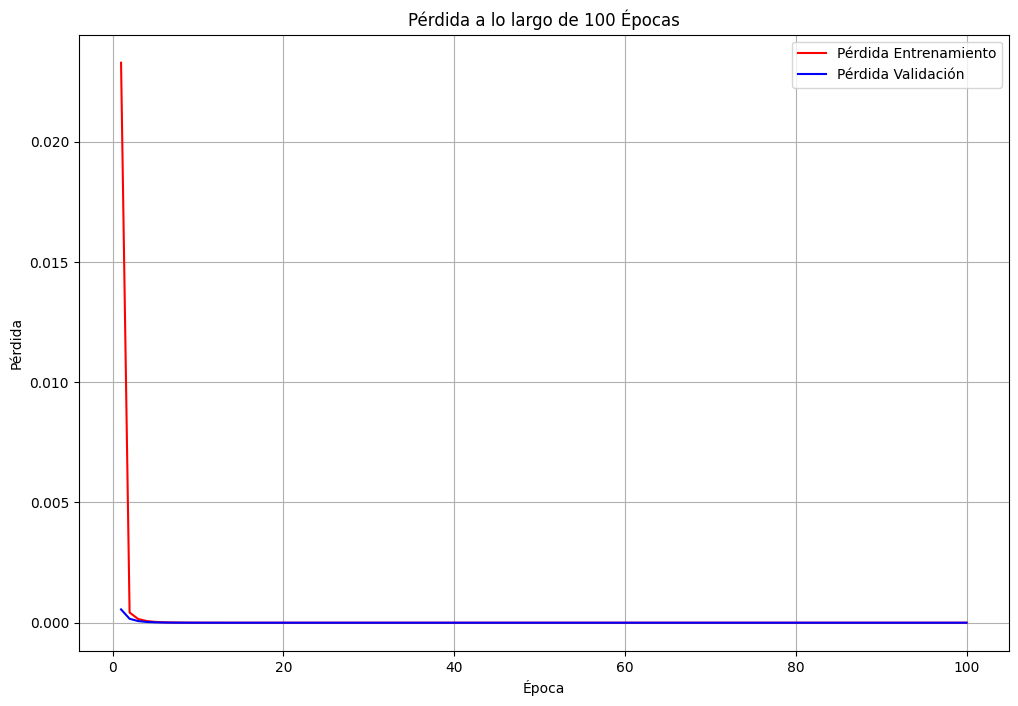

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

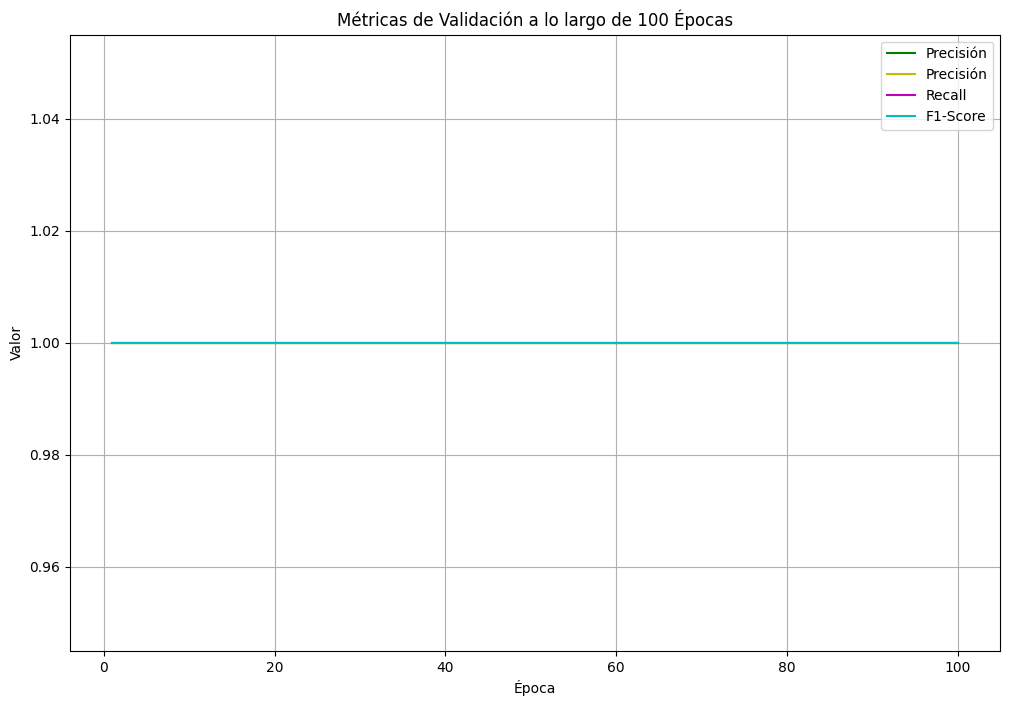

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


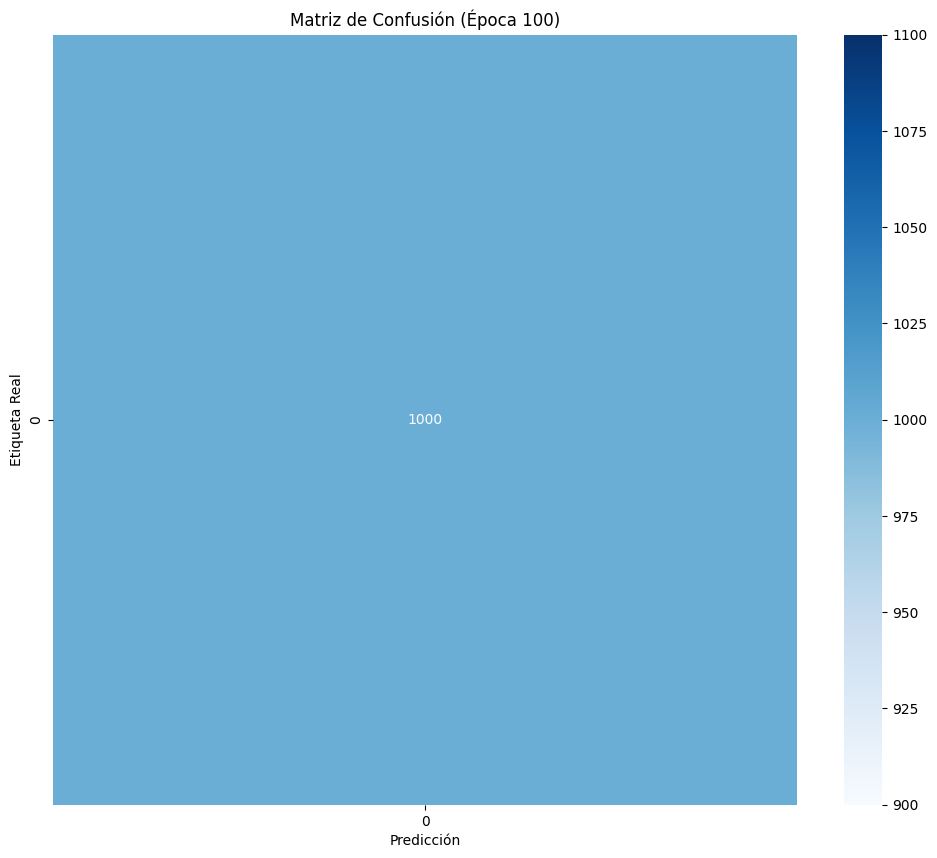

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo guardado en: transformer_from_scratch.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo descargado.


In [13]:
# Inicializar modelo
print("Inicializando modelo Transformer...")
model = TransformerClassifier(vocab_size=vocab_size, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Listas para almacenar métricas
train_losses = []
valid_losses = []
valid_accuracies = []
valid_precisions = []
valid_recalls = []
valid_f1_scores = []

# Entrenar modelo
num_epochs = 100
print("Iniciando entrenamiento...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_prec, valid_rec, valid_f1, _, _ = evaluate(model, valid_loader, criterion)

    # Almacenar métricas
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    valid_precisions.append(valid_prec)
    valid_recalls.append(valid_rec)
    valid_f1_scores.append(valid_f1)

    print(f"Época {epoch+1}/{num_epochs}")
    print(f"  Pérdida Entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida Validación: {valid_loss:.4f}")
    print(f"  Precisión Validación: {valid_prec:.4f}")
    print(f"  Recall Validación: {valid_rec:.4f}")
    print(f"  F1-Score Validación: {valid_f1:.4f}")

# Generar gráficas al final con el progreso total
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_losses, 'r-', label='Pérdida Entrenamiento')
plt.plot(epochs, valid_losses, 'b-', label='Pérdida Validación')
plt.title('Pérdida a lo largo de 100 Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')
plt.show()
files.download('loss_plot.png')

plt.figure(figsize=(12, 8))
plt.plot(epochs, valid_accuracies, 'g-', label='Precisión')
plt.plot(epochs, valid_precisions, 'y-', label='Precisión')
plt.plot(epochs, valid_recalls, 'm-', label='Recall')
plt.plot(epochs, valid_f1_scores, 'c-', label='F1-Score')
plt.title('Métricas de Validación a lo largo de 100 Épocas')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.savefig('metrics_plot.png')
plt.show()
files.download('metrics_plot.png')

# Evaluar una última vez para la matriz de confusión
valid_loss, valid_acc, valid_prec, valid_rec, valid_f1, all_preds, all_labels = evaluate(model, valid_loader, criterion)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (Época 100)')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.savefig('confusion_matrix.png')
plt.show()
files.download('confusion_matrix.png')

# Guardar modelo
model_path = "transformer_from_scratch.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en: {model_path}")
files.download(model_path)
print("Modelo descargado.")